# Google Data Analytics Capstone Outtakes

Some code and charts I did for `google-data-analytics-capstone.ipynb` that didn't seem useful in the final produt.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import requests
%pip install seaborn
import seaborn as sns
import duckdb

%load_ext sql

Note: you may need to restart the kernel to use updated packages.


In [2]:
INPUT_PATH = Path('./data')
WORKING_PATH = Path('./work')
con = duckdb.connect(str(WORKING_PATH / 'rides-2023.db'))

In [3]:
%sql con
%config SqlMagic.displaylimit = 20

## Descriptive Statistcs

In [4]:
descriptive_stats = con.sql("""
SELECT member_casual,
        MIN(distance) mindist, 
        ROUND(AVG(distance), 2) avgdist,
        MEDIAN(distance) meddist,
        MAX(distance) maxdist, 
        MIN(duration) mindur, 
        MAX(duration) maxdur,
        MIN(duration_minutes) mindurm,
        ROUND(AVG(duration_minutes),2) avgdurm,
        MEDIAN(duration_minutes) meddurm,
        MAX(duration_minutes) maxdurm
FROM rides
GROUP BY ROLLUP (member_casual)
        """).df()

descriptive_stats

,member_casual,mindist,avgdist,meddist,maxdist,mindur,maxdur,mindurm,avgdurm,meddurm,maxdurm
0,None,0.0,2097.67,1540.67,48928.80,0 days,0 days 04:59:43,0,14.31,10.0,299
1,member,0.0,2092.78,1507.22,40820.46,0 days,0 days 04:59:38,0,11.66,9.0,299
2,casual,0.0,2106.40,1598.14,48928.80,0 days,0 days 04:59:43,0,19.03,12.0,299


## Member vs. Casual User rides by month/weekday

In the end, showing the percentage of rides taken by members produce more readable graphs.

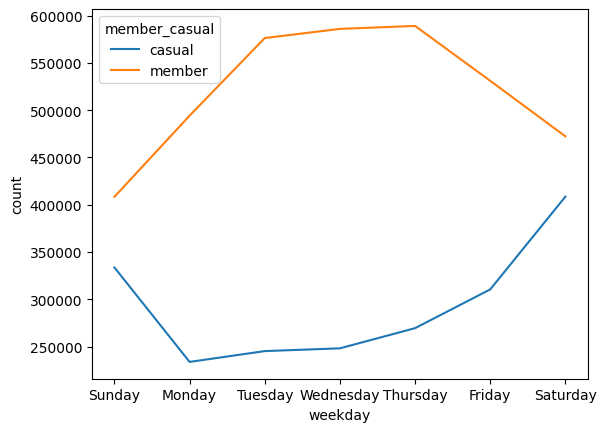

In [5]:
by_weekday = con.sql("""
        SELECT ride_weekday, strftime(started_at, '%A') weekday, member_casual, COUNT(ride_id) count
        FROM rides
        GROUP BY ride_weekday, strftime(started_at, '%A'), member_casual
        ORDER BY ride_weekday, member_casual
    """)

_df = by_weekday.df()

sns.lineplot(y="count", x="weekday", hue="member_casual", data=_df)

plt.show()

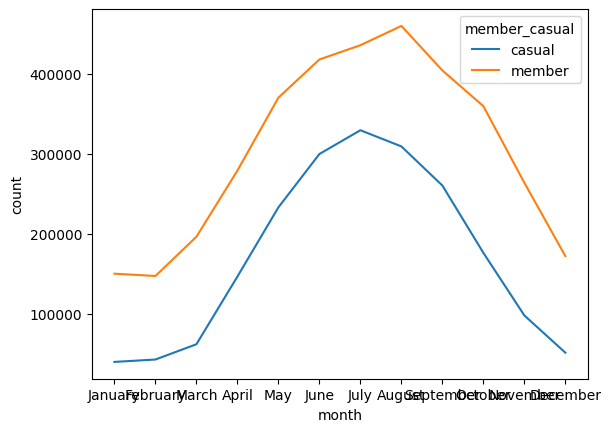

In [6]:
by_month = con.sql("""
    SELECT month(started_at) monthnum,
        strftime(started_at, '%B') "month", 
        member_casual, COUNT(ride_id) count
    FROM rides
    GROUP BY month(started_at), strftime(started_at, '%B'), member_casual
    ORDER BY month(started_at), member_casual
""")

_df = by_month.df()

sns.lineplot(y="count", x="month", hue="member_casual", data=_df)

plt.show()

## Ride Duration Quantiles

This comparison of members vs. casual users seemed interesting (casual users tend to take longer rides), but at the moment I couldn't see what to do with it.

In [7]:
%%sql
WITH duration_deciles_array AS (
    SELECT 
        QUANTILE_DISC(duration_seconds, [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]) dur_deciles,
    FROM rides
), 
duration_deciles AS ( SELECT UNNEST(dur_deciles) dec_sec FROM duration_deciles_array ),
duration_decile_ranges AS ( SELECT dec_sec, LEAD(dec_sec, 1) OVER () dec_max FROM duration_deciles ),
duration_decile_counts AS (
    SELECT dec_sec, COALESCE(dec_max, 10000000) dec_max,
        (SELECT COUNT(*) FROM rides WHERE duration_seconds >= dec_sec and duration_seconds < COALESCE(dec_max, 100000) AND member_casual = 'member') member_rides,
        (SELECT COUNT(*) FROM rides WHERE duration_seconds >= dec_sec and duration_seconds < COALESCE(dec_max, 100000) AND member_casual = 'casual') casual_rides,
        (SELECT COUNT(*) FROM rides WHERE duration_seconds >= dec_sec and duration_seconds < COALESCE(dec_max, 100000)) total_rides,
    FROM duration_decile_ranges
)
SELECT ROUND(dec_sec/60, 2) min_minutes, ROUND(dec_max/60, 2) max_minutes, member_rides, casual_rides, 
    ROUND(member_rides / (member_rides+casual_rides) * 100, 1) AS member_pct,
    total_rides
FROM duration_decile_counts

Running query in 'DuckDBPyConnection'

min_minutes,max_minutes,member_rides,casual_rides,member_pct,total_rides
0.0,3.2,418529,151030,73.5,569559
3.2,4.7,423526,144059,74.6,567585
4.7,6.13,407442,162458,71.5,569900
6.13,7.7,396835,177404,69.1,574239
7.7,9.5,380279,187374,67.0,567653
9.5,11.75,374809,198577,65.4,573386
11.75,14.78,360946,208535,63.4,569481
14.78,19.48,348176,223382,60.9,571558
19.48,28.83,322523,248829,56.4,571352
28.83,166666.67,223915,347289,39.2,571204


## Minimum/Maximum Latitude and Longitude

Originally used when I started exploring mapping. The Bing API I used in the end automatically sets the bounding box based on the data points you feed it.

In [8]:
%%sql
WITH points AS (
    SELECT start_lat latitude, start_lng longitude FROM rides
        WHERE start_lat != 0 AND start_lng != 0
    UNION SELECT end_lat, end_lng FROM rides
        WHERE end_lat != 0 AND end_lng != 0
)
SELECT min(latitude) minlat, max(latitude) maxlat, 
        min(longitude) minlong, max(longitude) maxlong
FROM points

Running query in 'DuckDBPyConnection'

minlat,maxlat,minlong,maxlong
41.61,42.18,-88.16,-87.44


In [9]:
con.close()